In [ ]:
!pip install -q -U kaggle_environments
!pip install -q -U pydash

In [ ]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

from random import randrange

Создадим агентов, у которых будет заложена разная логика игры

**0** - у нас будет означать камень


**1** - бумагу


**2** - ножницы

Создадим самых простых агентов, которые будут показывать одно и то же

In [ ]:
%%writefile only_rock.py

#Агент, который показывает все время камень

def only_rock(observation, configuration):
    return 0

Overwriting only_rock.py


In [ ]:
%%writefile only_paper.py

#Агент, который показывает все время бумагу

def only_paper(observation, configuration):
    return 1

Overwriting only_paper.py


In [ ]:
%%writefile only_scissors.py

# Агент, который показывает все время ножницы

def only_scissors(observation, configuration):
    return 2

Overwriting only_scissors.py


Попробуем теперь использовать информацию о прошлых действиях противника. Опишем агента, который производит то же самое действие, что и оппонент на прошлом ходу

In [ ]:
%%writefile copy_opponent.py
import random

def copy_opponent(observation, configuration):
    #in case we have information about opponent last move
    if observation.step > 0:
        return observation.lastOpponentAction
    #initial step
    else:
        return random.randrange(0, configuration.signs)

Overwriting copy_opponent.py


Теперь создадим бота, который будет выдавать рандомные комбинации


In [ ]:
 %%writefile random_agent.py


import random

def random_agent(observation, configuration):
    return random.randint(0, 2)

Overwriting random_agent.py


Добавим пару агентов из сети



In [ ]:
 %%writefile rps.py

 
action_histogram = {}


def statistical(observation, configuration):
    global action_histogram
    if observation.step == 0:
        action_histogram = {}
        return
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

Overwriting rps.py


In [ ]:
%%writefile stats_base_agent.py

import random
import pydash
from collections import Counter

# нужна какая-то история для функционирования этого агента
history = {
    "guess":      [0,1,2],
    "prediction": [0,1,2],
    "expected":   [0,1,2],
    "action":     [1,2,0],
    "opponent":   [0,1],
    "rotn":       [0,1],
}

def statistical_prediction_agent(observation, configuration):    
    global history
    actions          = list(range(configuration.signs))   
    last_action      = history['action'][-1]
    prev_opp_action  = history['opponent'][-1]
    opponent_action  = observation.lastOpponentAction if observation.step > 0 else 2
    rotn             = (opponent_action - prev_opp_action) % configuration.signs

    history['opponent'].append(opponent_action)
    history['rotn'].append(rotn)
    
    move_frequency   = Counter(history['rotn'])
    action_frequency = Counter(zip(history['action'], history['rotn'])) 
    move_weights     = [   move_frequency.get(n, 1) 
                         + action_frequency.get((last_action,n), 1) 
                         for n in range(configuration.signs) ] 
    guess            = random.choices( population=actions, weights=move_weights, k=1 )[0]
    
    guess_frequency  = Counter(zip(history['guess'], history['rotn']))
    guess_weights    = [ guess_frequency.get((guess,n), 1) 
                         for n in range(configuration.signs) ]
    prediction       = random.choices( population=actions, weights=guess_weights, k=1 )[0]

    pred_frequency   = Counter(zip(history['prediction'], history['rotn']))
    pred_weights     = [ pred_frequency.get((prediction,n), 1) 
                         for n in range(configuration.signs) ]
    expected         = random.choices( population=actions, weights=pred_weights, k=1 )[0]

    
    pure_random_chance = observation.step / (configuration.episodeSteps * 2)
    if random.random() < pure_random_chance:
        action = random.randint(0, configuration.signs-1)
        is_pure_random_chance = True
    else:
        # Play the +1 counter move
        # action = (expected + 1) % configuration.signs                  # without rotn
        action = (opponent_action + expected + 1) % configuration.signs  # using   rotn
        is_pure_random_chance = False
    
    # Persist state
    history['guess'].append(guess)
    history['prediction'].append(prediction)
    history['expected'].append(expected)
    history['action'].append(action)

    # Print debug information
    print('step                      = ', observation.step)
    print('opponent_action           = ', opponent_action)
    print('guess,      move_weights  = ', guess,      move_weights)
    print('prediction, guess_weights = ', prediction, guess_weights)
    print('expected,   pred_weights  = ', expected,   pred_weights)
    print('action                    = ', action)
    print('pure_random_chance        = ', f'{100*pure_random_chance:.2f}%', is_pure_random_chance)
    print()
    
    return action

Overwriting stats_base_agent.py


In [ ]:
%%writefile markov_agent.py

import numpy as np
import collections

def markov_agent(observation, configuration):
    k = 2
    global table, action_seq
    if observation.step % 250 == 0: # refresh table every 250 steps
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])    
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
            action_seq.extend([observation.lastOpponentAction, action])
        else:
            action_seq.append(action)
        return action
    # update table
    key = ''.join([str(a) for a in action_seq[:-1]])
    table[key][observation.lastOpponentAction] += 1
    # update action seq
    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    # predict opponent next move
    key = ''.join([str(a) for a in action_seq[:-1]])
    if observation.step < 500:
        next_opponent_action_pred = np.argmax(table[key])
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum()) # add stochasticity for second part of the game
    # make an action
    action = (next_opponent_action_pred + 1) % 3
    # if high probability to lose -> let's surprise our opponent with sudden change of our strategy
    if observation.step > 900:
        action = next_opponent_action_pred
    action_seq[-1] = action
    return int(action)

Overwriting markov_agent.py


Составим список всех агентов и добавим его в отдельную переменную

In [ ]:
name_list = ['only_rock.py', 'only_paper.py', 'only_scissors.py', 'copy_opponent.py', 'rps.py', 'random_agent.py', 'stats_base_agent.py', 'markov_agent.py']

In [ ]:
n_agents = len(name_list)

scores = np.zeros((n_agents, n_agents), dtype=np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


# **Проводим турнир**

In [ ]:
for ind_agent_1 in range(len(name_list)):
     
    for ind_agent_2 in range(ind_agent_1 + 1, len(name_list)):
         
        #print("LOG:",name_list[ind_agent_1]," vs ",name_list[ind_agent_2])
        
        current_score = evaluate(
            "rps", 
            [name_list[ind_agent_1], name_list[ind_agent_2]], 
            configuration={"episodeSteps": 50}
        )
        
        scores[ind_agent_1, ind_agent_2] = current_score[0][0]
        scores[ind_agent_2, ind_agent_1] = current_score[0][1]
      
print(scores)      
    

[[  0 -49  49   0 -48   0   0 -45]
 [ 49   0 -49   0 -47   0 -23 -42]
 [-49  49   0   0 -49   0 -24 -24]
 [  0   0   0   0   0   0   0 -26]
 [ 48  47  49   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0  23  24   0   0   0   0   0]
 [ 45  42  24  26   0   0   0   0]]


Визуализируем данные

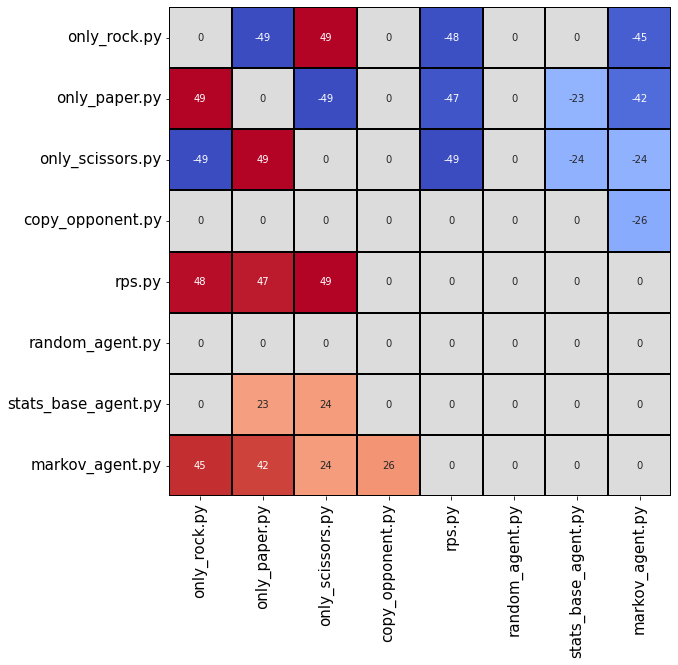

In [ ]:

df_scores = pd.DataFrame(
    scores, 
    index=name_list, 
    columns=name_list,
)


plt.figure(figsize=(9, 9))
sns.heatmap(
    df_scores, annot=True, cbar=False, 
    cmap='coolwarm', linewidths=1, 
    linecolor='black', fmt="d",
)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15);

In [ ]:
df_scores['mean'] = df_scores.mean(axis=0)

df_scores['mean']

only_rock.py           11.625
only_paper.py          14.000
only_scissors.py       12.125
copy_opponent.py        3.250
rps.py                -18.000
random_agent.py         0.000
stats_base_agent.py    -5.875
markov_agent.py       -17.125
Name: mean, dtype: float64

# **Вывод**

Из представленных агентов лучше всего себя показала тактика однозначного выбора, когда показывается только камень или только бумага или только ножницы.
